In [1]:
import numpy as np
import pandas as pd

In [10]:
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import xarray as xr
import shutil
import gzip
from zipfile import ZipFile
from fire import Fire
import urllib.request
from urllib.error import HTTPError

In [3]:
start_date='2020-01-01'
stop_date = '2020-01-02'

In [4]:
dates = pd.DatetimeIndex(np.arange(start_date, stop_date, dtype='datetime64[h]'))
dates

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               '2020-01-01 10:00:00', '2020-01-01 11:00:00',
               '2020-01-01 12:00:00', '2020-01-01 13:00:00',
               '2020-01-01 14:00:00', '2020-01-01 15:00:00',
               '2020-01-01 16:00:00', '2020-01-01 17:00:00',
               '2020-01-01 18:00:00', '2020-01-01 19:00:00',
               '2020-01-01 20:00:00', '2020-01-01 21:00:00',
               '2020-01-01 22:00:00', '2020-01-01 23:00:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
d = dates[0]

In [20]:
def download_mrms_from_server(year, month, day, hour, path):
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    hour = str(hour).zfill(2)
    fn = f'RadarOnly_QPE_01H_00.00_{year}{month}{day}-{hour}0000.grib2.gz'
    url = f"https://mtarchive.geol.iastate.edu/{year}/{month}/{day}/mrms/ncep/RadarOnly_QPE_01H/" + fn
    gz_fn = f'{path}/{fn}'
    urllib.request.urlretrieve(url, gz_fn)
    return gz_fn

In [16]:
tmp_path = '/datadrive/tmp/'

In [22]:
download_mrms_from_server(d.year, d.month, d.day, d.hour, tmp_path)

https://mtarchive.geol.iastate.edu/2020/01/01/mrms/ncep/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20200101-000000.grib2.gz


'/datadrive/tmp//RadarOnly_QPE_01H_00.00_20200101-000000.grib2.gz'

In [23]:
def gunzip_file(gz_fn, out_fn=None):
    if not out_fn: out_fn = gz_fn[:-3]
    with gzip.open(gz_fn, 'rb') as f_in:
        with open(out_fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [24]:
gunzip_file('/datadrive/tmp//RadarOnly_QPE_01H_00.00_20200101-000000.grib2.gz')

In [25]:
!ls /datadrive/tmp/

20190901_00_00.grib2  20191002_00_24.grib2
20190901_00_06.grib2  20191002_00_30.grib2
20190901_00_12.grib2  20191002_00_36.grib2
20190906_12_12.grib2  2020050100
20190906_12_18.grib2  2020050100.zip
20190906_12_24.grib2  2020050106.zip
20190906_12_30.grib2  2020081000.zip
20190906_12_36.grib2  2020082900.zip
20190927_12_00.grib2  2020102313
20190927_12_06.grib2  2020102313.zip
20191001_12_00.grib2  RadarOnly_QPE_01H_00.00_20200101-000000.grib2
20191001_12_06.grib2  RadarOnly_QPE_01H_00.00_20200101-000000.grib2.gz
20191001_12_12.grib2  test.nc
20191001_12_18.grib2  test2.nc
20191001_12_24.grib2  test3.nc
20191001_12_30.grib2  test4.nc
20191001_12_36.grib2  test5.nc
20191002_00_00.grib2  test6.nc
20191002_00_06.grib2  test7.nc
20191002_00_12.grib2  test8.nc
20191002_00_18.grib2  test9.nc


In [26]:
ds = xr.open_dataset('/datadrive/tmp//RadarOnly_QPE_01H_00.00_20200101-000000.grib2', engine='cfgrib')

In [27]:
ds

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  int64 ...
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] ...
Data variables:
    paramId_0       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2021-01-22T13:10:07 GRIB to CDM+CF via cfgrib-0....

In [28]:
ds = ds.rename({
                'paramId_0': 'tp',
                'latitude': 'lat',
                'longitude': 'lon',
            }).drop(['valid_time', 'heightAboveSea', 'step']).expand_dims(dim='time')

In [29]:
ds

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (time, lat, lon) float32 -3.0 -3.0 -3.0 -3.0 ... -3.0 -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2021-01-22T13:10:07 GRIB to CDM+CF via cfgrib-0....

In [31]:
ds = xr.open_mfdataset(['/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-010000.nc', '/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-020000.nc', '/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-030000.nc', '/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-040000.nc', '/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-050000.nc', '/datadrive/mrms/RadarOnly_QPE_01H/RadarOnly_QPE_01H_00.00_20180101-060000.nc'])

In [32]:
ds

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000, time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T01:00:00 ... 2018-01-01T06:00:00
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2021-01-23T10:10:17 GRIB to CDM+CF via cfgrib-0....

In [34]:
ds.sum('time')

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000)
Coordinates:
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (lat, lon) float32 dask.array<chunksize=(3500, 7000), meta=np.ndarray>

In [36]:
ds.rolling()

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T03:30:00
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>

In [39]:
ds.load().rolling(time=6).sum().dropna('time')

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T06:00:00
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (time, lat, lon) float32 -18.0 -18.0 -18.0 ... -18.0 -18.0 -18.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2021-01-23T10:10:17 GRIB to CDM+CF via cfgrib-0....

In [40]:
hours = range(-5, 1)

In [44]:
[h for h in hours if h >= 0 else h]

SyntaxError: invalid syntax (<ipython-input-44-f935f39bdb4c>, line 1)

In [54]:
ds = xr.open_mfdataset('/datadrive/mrms/raw/RadarOnly_QPE_06H/*.nc')

In [55]:
ds

<xarray.Dataset>
Dimensions:  (lat: 3500, lon: 7000, time: 2)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T06:00:00 2018-01-01T12:00:00
  * lat      (lat) float64 54.99 54.98 54.98 54.97 ... 20.04 20.03 20.02 20.01
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2021-01-23T10:10:17 GRIB to CDM+CF via cfgrib-0....

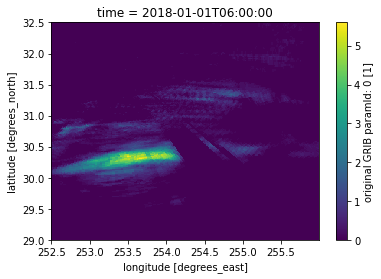

In [53]:
ds.tp[0, 2250:2600, 2250:2600].plot()